In [2]:
########################################################
# Bonus Chapter 3 - Notebook 1: Improving the model
########################################################

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
import h5py
import numpy as np

from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

In [3]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
# Load and process the MNIST data

random_seed = 42

# load the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# cast the sample data to the current Keras floating-point type
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# save labels in their non-one-hot form
original_y_train = np.copy(y_train)
original_y_test = np.copy(y_test)

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, number_of_classes)
y_test = to_categorical(y_test, number_of_classes)

# reshape to 2D grid, one line per image
X_train = X_train.reshape(X_train.shape[0], number_of_pixels)
X_test = X_test.reshape(X_test.shape[0], number_of_pixels)

In [5]:
# These variables are assigned during our pre-processing step. 
# We'll just assign them directly here for this demonstration.
number_of_pixels = 28*28  # size of an MNIST image
number_of_classes = 10    # MNIST images are digits 0 to 9

def make_one_hidden_layer_model():
    # create an empty model
    model = Sequential()
    # add a fully-connected hidden layer with #nodes = #pixels
    model.add(Dense(number_of_pixels, activation='relu',
                    input_shape=[number_of_pixels]))
    # add an output layer with softmax activation
    model.add(Dense(number_of_classes, activation='softmax'))
    # compile the model to turn it from specification to code
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [6]:
def make_two_hidden_layers_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, input_shape=[number_of_pixels], 
                    activation='relu'))
    model.add(Dense(number_of_pixels, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def make_hidden_layer_n_neurons(num_neurons):
    model = Sequential()
    model.add(Dense(num_neurons, input_shape=[number_of_pixels], 
                    activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# make a general model of any number of dense layers, each optionally followed by dropout
def make_layers_model(neurons_per_layer, dropout_per_layer, learning_rate=0.001):
    model = Sequential()
    for i in range(len(neurons_per_layer)):
        kwargs = { 'kernel_initializer': 'normal', 'activation': 'relu' }
        if i==0:
            kwargs['input_dim'] = number_of_pixels
        if dropout_per_layer[i]:
            kwargs['kernel_constraint'] = MaxNorm(3)
        model.add(Dense(neurons_per_layer[i], **kwargs))
        if dropout_per_layer[i]:
            model.add(Dropout(0.2))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    return model

In [7]:
# A little utility to draw accuracy and loss plots
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, plot_title, filename):
    xs = range(len(history.history['accuracy']))
    # manually change legend location to 'best' when the locations
    # here don't look good. 

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    #file_helper.save_figure(filename)
    plt.show()

In [10]:
# A utility to let us try out lots of variations of models,
# batch size, and early stopping, and plot and save the results.
#
# We use Python's kwargs mechanism as a way to package up the parameters
# to a function in a dictionary. It's a little fancy but it saves a huge
# amount of code. See the Python docs for how this feature works.
#   

def run_and_report(model, plot_title=None, filename='generic-filename', 
                   epochs=100, batch_size=256, verbosity=2, stop_early=False):
    np.random.seed(random_seed)
    kwargs = { 'validation_data': (X_test, y_test), 'epochs': epochs,
              'batch_size': batch_size, 'verbose': verbosity }
    if stop_early:
        early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        kwargs['callbacks'] = [early_stopper]
    history = model.fit(X_train, y_train, **kwargs)
    plot_accuracy_and_loss(history, plot_title, filename)
    # 20211107 cwr 
    #models_folder_name = 'NB09-checkpointed-models'
    models_folder_name = '/Users/cwr/Desktop/SavedModels/NB09-checkpointed-models'

    #file_helper.check_for_directory(models_folder_name)

    # 20211107 cwr use .tf file format
    # filename = models_folder_name+'/'+filename+'-'+str(epochs)+'-epochs.h5'
    # model.save(filename)
    filename = models_folder_name+'/'+filename+'-'+str(epochs)+'-epochs.tf'
    model.save(filename,save_format='tf')
    
    return history

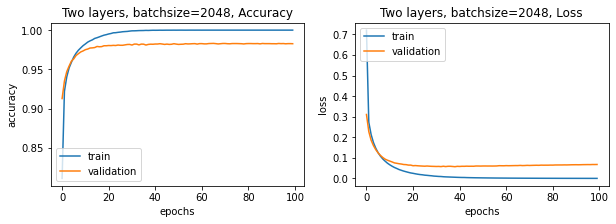

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2021-11-07 16:54:40.661551: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: NB09-checkpointed-models/two-layers-batch-2048-100-epochs.tf/assets
batchsize  2048  elapsed time= 145.11849093437195


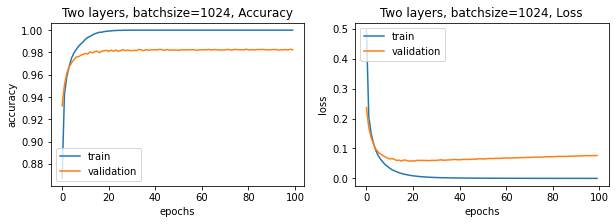

INFO:tensorflow:Assets written to: NB09-checkpointed-models/two-layers-batch-1024-100-epochs.tf/assets
batchsize  1024  elapsed time= 185.4045958518982


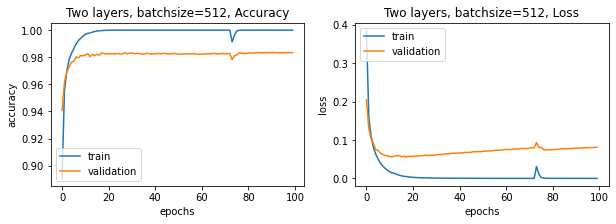

INFO:tensorflow:Assets written to: NB09-checkpointed-models/two-layers-batch-512-100-epochs.tf/assets
batchsize  512  elapsed time= 254.26078486442566


In [11]:
#
# WARNING: If you're training on a CPU (that is, without a GPU),
# then as batch sizes decrease, running time increases FAST.
# Without a GPU, be careful with batch sizes smaller than 256.
# I'm using big batches here so the notebook runs in less than a
# few days. If you have a fast machine and/or a great GPU, it would
# be instructive to include more sizes, as in the commented definition
# of batch_sizes.
#
import time
history_list = []
time_list = []

#batch_sizes = [2048, 1024, 512, 256, 128, 64, 32, 16, 8]
#batch_sizes = [2048, 1024, 512, 256]
batch_sizes = [2048, 1024, 512]
for batchsize in batch_sizes:
    model = make_one_hidden_layer_model()
    plot_title = 'Two layers, batchsize='+str(batchsize)
    filename = 'two-layers-batch-'+str(batchsize)
    start_time = time.time()
    history = run_and_report(model, plot_title, filename, batch_size=batchsize, verbosity=0)
    end_time = time.time()
    elapsed_time = end_time-start_time
    history_list.append(history)
    print("batchsize ",batchsize," elapsed time=",elapsed_time)
    time_list.append(elapsed_time)

In [14]:
# ...
#
#######################################################
# Bonus Chapter 3 - Notebook 2: Keras with scikit-learn
#######################################################

In [15]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import h5py
import numpy as np

from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

In [16]:
random_seed = 42
np.random.seed(random_seed)

# load the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# cast the sample data to the current Keras floating-point type
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# save y_train and y_test when used with scikit-learn
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, number_of_classes)
y_test = to_categorical(y_test, number_of_classes)

# reshape to 2D grid, one line per image
X_train = X_train.reshape(X_train.shape[0], number_of_pixels)
X_test = X_test.reshape(X_test.shape[0], number_of_pixels)

In [17]:
# Build a network of any number of (dense+ dropout) layers of the given size
def make_model(number_of_layers=2, neurons_per_layer=32, dropout_ratio=0.2, optimizer='adam'):
    model = Sequential()

    # first layer is special, because it sets input_shape
    model.add(Dense(neurons_per_layer, input_shape=[number_of_pixels],
        activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(dropout_ratio))
    # now add in all the rest of the dense-dropout layers
    for i in range(number_of_layers-1):
        append_dense_dropout_layer(model, neurons_per_layer, dropout_ratio)
    # wrap up with a softmax layer with 10 outputs
    model.add(Dense(number_of_classes,  activation='softmax'))
    # compile the model and return it
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model

def append_dense_dropout_layer(model, neurons_per_layer, dropout_ratio):
    model.add(Dense(neurons_per_layer, 
        activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(dropout_ratio))

In [20]:
# create the KerasClassifier that packages up our model maker for CV and grid search
#
# Wrap up our model-making function into a KerasClassifier, which
# will make it behave like a standard scikit-learn estimator.  We'll
# give all the arguments defaults which we can override later when
# we build the model as part of cross-validation or grid search.
# For instance, we will provide a value to number_of_layers, so this
# value will be passed to number_of_layers when make_model() is called.
#

kc_model = KerasClassifier(build_fn=make_model,
                          number_of_layers=2, neurons_per_layer=32,
                          nb_epoch=100, batch_size=128, verbose=0)

In [18]:
def run_grid_search(param_grid, filename, verbose=2):
# Run the first grid search
    np.random.seed(random_seed)
    grid_searcher = GridSearchCV(estimator=pipeline, param_grid=param_grid, verbose=verbose)
    search_results = grid_searcher.fit(X_train, original_y_train)

    print('---- GRID SEARCH ----')
    print('mean test scores: {}\n'.format(search_results.cv_results_['mean_test_score']))
    best_index = np.argmax(search_results.cv_results_['mean_test_score'])
    print('best set of parameters:\n  index {}\n  {}\n'.format(best_index, 
                                                               search_results.cv_results_['params'][best_index]))

    params = search_results.cv_results_['params']
    dict_vals = [params[i].values() for i in range(len(params))]
    name_list =[[str(v) for v in dv] for dv in dict_vals]
    xlabels = ['-'.join(name_list[i]) for i in range(len(name_list))]
    plt.plot(search_results.cv_results_['mean_test_score'], 'r')
    plt.xticks(np.arange(len(xlabels)), xlabels, rotation='vertical')
    file_helper.save_figure(filename+'-mean-test-scores')
    plt.show()
    return search_results

In [21]:
# Run cross validation on our data, without a normalization step (that is, no pipeline)
np.random.seed(random_seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
cv_results1 = cross_val_score(kc_model, X_train, original_y_train, cv=kfold, verbose=2)
print("results1 ={}\nresults1.mean={}".format(cv_results1, cv_results1.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  14.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s


[CV] END .................................................... total time=   3.8s
[CV] END .................................................... total time=   4.2s
[CV] END .................................................... total time=   4.0s
[CV] END .................................................... total time=   4.3s
[CV] END .................................................... total time=   4.2s
[CV] END .................................................... total time=   4.4s
[CV] END .................................................... total time=   4.1s
[CV] END .................................................... total time=   4.3s
[CV] END .................................................... total time=   4.2s
results1 =[0.91333336 0.91633332 0.91533333 0.91133332 0.90499997 0.90983331
 0.90799999 0.91100001 0.91333336 0.90983331]
results1.mean=0.9113333284854889


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   52.3s finished


In [22]:
# Run a CV step with a pipeline
np.random.seed(random_seed)
pipeline = make_pipeline(MinMaxScaler(), kc_model)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
cv_results2 = cross_val_score(pipeline, X_train, original_y_train, cv=kfold, verbose=2)
print("results2 ={}\nresults2.mean={}".format(cv_results2, cv_results2.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   4.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[CV] END .................................................... total time=   4.3s
[CV] END .................................................... total time=   4.1s
[CV] END .................................................... total time=   4.2s
[CV] END .................................................... total time=   4.7s
[CV] END .................................................... total time=   4.4s
[CV] END .................................................... total time=   4.7s
[CV] END .................................................... total time=   4.2s
[CV] END .................................................... total time=   4.5s
[CV] END .................................................... total time=   4.4s
results2 =[0.90899998 0.91399997 0.91366667 0.91350001 0.91533333 0.9145
 0.91166669 0.90983331 0.91250002 0.9095    ]
results2.mean=0.9123499989509583


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   43.8s finished
